In [1]:
# google drive connect
Copied_path = '/content/drive/MyDrive/Colab Notebooks/MyPaper/GlocalSTN' # Paste target directory here
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir(Copied_path)

Mounted at /content/drive


In [ ]:
#FourSquare Preprocessing
import pandas as pd
file = pd.read_csv('./data2/dataset_TSMC2014_TKY.txt', encoding='cp1252', sep='\t', names=['User ID', 'Venue ID', 'Venue category ID', 'Venue category name','Latitude', 'Longitude', 'Timezone offset', 'UTC time'])
map_table = pd.read_csv('./data2/cate4sq.csv', names=['large', 'small'])

file['cate_grp'] = 0

for i in range(file.shape[0]) :
  try :
    file['cate_grp'][i] = map_table[map_table['small'] == file['Venue category name'][i]].iloc[0,0]
  except :
    file['cate_grp'][i] = 'Uncategorized'

file.to_csv('./data2/foursq_wCat.csv')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.p

# 새 섹션

In [ ]:
import numpy as np
import datetime
import pandas as pd

file = pd.read_csv('./data2/foursq_wCat.csv')

num_of_xgrid = 12 # x 좌표를 몇개로 나눌건지, ST Resnet과 동일하게 맞출때
num_of_timegrid = 150 * 8 # 하루를 8등분으로 나눔, 한타임 슬롯이 3시간

# x, y 좌표 binning        
#num_of_xgrid = 21 # x 좌표를 몇개로 나눌건지
width_of_xgrid = (float(file['Latitude'].max()) - float(file['Latitude'].min())) / num_of_xgrid
bin_of_x = np.arange(float(file['Latitude'].min()), float(file['Latitude'].max())+(width_of_xgrid/2), width_of_xgrid)
file['x'] = pd.cut(file['Latitude'].astype(float), bins=bin_of_x, labels=range(0, num_of_xgrid))

# y 좌표는 x, y 좌표 span의 비율만큼 위에 x grid 값에서 곱해서 구함, 최대 999보다 작아야 함
#num_of_ygrid = 21 # ST Resnet과 동일하게 맞출때
num_of_ygrid = int(num_of_xgrid * (float(file['Longitude'].max()) - float(file['Longitude'].min())) / (float(file['Latitude'].max()) - float(file['Latitude'].min())))
print("x grid =", num_of_xgrid)
print("y grid =", num_of_ygrid)
width_of_ygrid = (float(file['Longitude'].max()) - float(file['Longitude'].min())) / num_of_ygrid
bin_of_y = np.arange(float(file['Longitude'].min()), float(file['Longitude'].max())+(width_of_ygrid/2), width_of_ygrid)
file['y'] = pd.cut(file['Longitude'].astype(float), bins=bin_of_y, labels=range(0, num_of_ygrid))

file.drop(file[file['x'].isnull()].index, inplace=True)
file.drop(file[file['y'].isnull()].index, inplace=True)
file['xy'] = file['x'].astype(int)*1000 + file['y'].astype(int)
file.drop(file[file['xy'].isnull()].index, inplace=True)

file['UTC time'] = pd.to_datetime(file['UTC time'], format='%a %b %d %H:%M:%S +0000 %Y')


width_of_timegrid = (file['UTC time'].max() - file['UTC time'].min()) / num_of_timegrid
bin_of_time = np.arange(file['UTC time'].min(), file['UTC time'].max()+(width_of_timegrid/2), width_of_timegrid)
file['time_seq'] = pd.cut(file['UTC time'], bins=bin_of_time, labels=range(0, num_of_timegrid))
file.drop(file[file['time_seq'].isnull()].index, inplace=True)


drop_col_name=['User ID', 'Venue ID', 'Venue category ID','Venue category name', 'Latitude', 'Longitude', 'Timezone offset', 'UTC time','Unnamed: 0', 'x', 'y']
file = file.drop(drop_col_name, axis=1)
file['freq'] = 1

#file1 = file[file['cate_grp']=='Shop& Service'][['xy', 'time_seq']]
#result = file.groupby(['cate_grp','time_seq','xy'], as_index=False).size()
result = pd.DataFrame(pd.pivot_table(file, index=['cate_grp','time_seq','xy'], values='freq', aggfunc=np.sum)).reset_index()

result['x'] = result['xy'].astype(int)//1000
result['y'] = result['xy'].astype(int)%1000


matrix_row_num = result['y'].max() + 1
matrix_col_num = result['x'].max() + 1
matrix_index_num = num_of_timegrid + 1
#matrix_index_num = result['time_seq'].nunique()


crowd_flow_matrix = np.zeros((result['cate_grp'].nunique()+1, matrix_index_num, matrix_row_num, matrix_col_num))

image_index = 0
for i in range(0, result.shape[0]) :
    '''   
    if i > 0 :
        if (result.iloc[i,0] != result.iloc[i-1,0]) :
          image_index = 0
        elif (result.iloc[i,1] != result.iloc[i-1,1]) :
            image_index = image_index + 1
            #print(result.iloc[i,1], image_index)
    '''
    image_index = result.iloc[i,1]
    row_index = result.iloc[i,5] 
    col_index = result.iloc[i,4] 
    if result.iloc[i,0] == 'Arts& Entertainment' :
      cat_index = 0
    elif result.iloc[i,0] == 'College & University' :
      cat_index = 1
    elif result.iloc[i,0] == 'Event' :
      cat_index = 2
    elif result.iloc[i,0] == 'Food' :
      cat_index = 3
    elif result.iloc[i,0] == 'Nightlife Spot' :
      cat_index = 4
    elif result.iloc[i,0] == 'Outdoors & Recreation' :
      cat_index = 5
    elif result.iloc[i,0] == 'Professional & Other Places' :
      cat_index = 6
    elif result.iloc[i,0] == 'Residence' :
      cat_index = 7
    elif result.iloc[i,0] == 'Shop& Service' :
      cat_index = 8
    elif result.iloc[i,0] == 'Travel & Transport' :
      cat_index = 9
    else :
      cat_index = 10
       
    crowd_flow_matrix[cat_index, image_index, row_index, col_index] = result.iloc[i, 3]

#global_exclude_index = [1, 2, 4, 7]
for i in range(11) :
  #if i not in global_exclude_index:
    crowd_flow_matrix[11, : , : , : ] = crowd_flow_matrix[11, : , : , : ] + crowd_flow_matrix[i, : , : , : ]

zero_time_index = []
for j in range(matrix_index_num) :
  if crowd_flow_matrix[11, j , : , : ].sum() == 0 :
    #print("global zero")
    zero_time_index.append(j)


      #crowd_flow_matrix[k] = np.concatenate((crowd_flow_matrix[k, :j], crowd_flow_matrix[k, j+1:]), axis=0)
    #crowd_flow_matrix[11] = np.concatenate((crowd_flow_matrix[11, :j], crowd_flow_matrix[11, j+1:]), axis=0)


np.save('data_v2/m0_Ent', np.delete(crowd_flow_matrix[0,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m1_Col', np.delete(crowd_flow_matrix[1,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m2_Ev', np.delete(crowd_flow_matrix[2,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m3_Food', np.delete(crowd_flow_matrix[3,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m4_Night', np.delete(crowd_flow_matrix[4,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m5_Outdoor', np.delete(crowd_flow_matrix[5,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m6_Pro', np.delete(crowd_flow_matrix[6,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m7_Res', np.delete(crowd_flow_matrix[7,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m8_Shop', np.delete(crowd_flow_matrix[8,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m9_Tra', np.delete(crowd_flow_matrix[9,:,:,:], zero_time_index,axis=0))
np.save('data_v2/m10_Oth', np.delete(crowd_flow_matrix[10,:,:,:], zero_time_index,axis=0))
np.save('data_v2/global', np.delete(crowd_flow_matrix[11,:,:,:], zero_time_index,axis=0))



'''
np.save('data2/m0_Ent', crowd_flow_matrix[0,:,:,:])
np.save('data2/m1_Col', crowd_flow_matrix[1,:,:,:])
np.save('data2/m2_Ev', crowd_flow_matrix[2,:,:,:])
np.save('data2/m3_Food', crowd_flow_matrix[3,:,:,:])
np.save('data2/m4_Night', crowd_flow_matrix[4,:,:,:])
np.save('data2/m5_Outdoor', crowd_flow_matrix[5,:,:,:])
np.save('data2/m6_Pro', crowd_flow_matrix[6,:,:,:])
np.save('data2/m7_Res', crowd_flow_matrix[7,:,:,:])
np.save('data2/m8_Shop', crowd_flow_matrix[8,:,:,:])
np.save('data2/m9_Tra', crowd_flow_matrix[9,:,:,:])
np.save('data2/m10_Oth', crowd_flow_matrix[10,:,:,:])
np.save('data2/global', crowd_flow_matrix[11,:,:,:])
'''     


x grid = 12
y grid = 14


"\nnp.save('data2/m0_Ent', crowd_flow_matrix[0,:,:,:])\nnp.save('data2/m1_Col', crowd_flow_matrix[1,:,:,:])\nnp.save('data2/m2_Ev', crowd_flow_matrix[2,:,:,:])\nnp.save('data2/m3_Food', crowd_flow_matrix[3,:,:,:])\nnp.save('data2/m4_Night', crowd_flow_matrix[4,:,:,:])\nnp.save('data2/m5_Outdoor', crowd_flow_matrix[5,:,:,:])\nnp.save('data2/m6_Pro', crowd_flow_matrix[6,:,:,:])\nnp.save('data2/m7_Res', crowd_flow_matrix[7,:,:,:])\nnp.save('data2/m8_Shop', crowd_flow_matrix[8,:,:,:])\nnp.save('data2/m9_Tra', crowd_flow_matrix[9,:,:,:])\nnp.save('data2/m10_Oth', crowd_flow_matrix[10,:,:,:])\nnp.save('data2/global', crowd_flow_matrix[11,:,:,:])\n"

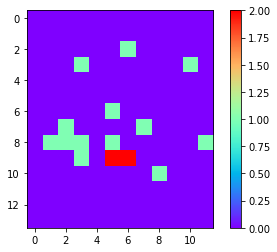

In [ ]:
import matplotlib.pylab as plt
import numpy as np
#matrix = crowd_flow_matrix[20,200,1,:,:]
matrix = np.load('./data2/m3_Food.npy')
matrix_plot = matrix[200,:,:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(matrix_plot, interpolation='nearest', cmap=plt.cm.rainbow)

plt.colorbar()
plt.show()

In [ ]:
matrix.shape

(797, 14, 12)

(797, 14, 12)


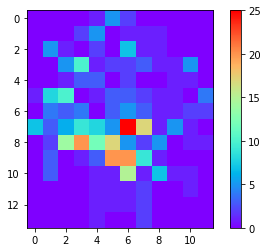

In [ ]:
import matplotlib.pylab as plt
import numpy as np
#matrix = crowd_flow_matrix[20,200,1,:,:]
matrix = np.load('./data2/global.npy')
print(matrix.shape)
matrix = matrix[200,:,:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.rainbow)

plt.colorbar()
plt.show()

In [ ]:
import numpy as np
from scipy import stats

file_list = ['data_v2/m0_Ent', 'data_v2/m1_Col','data_v2/m2_Ev', 'data_v2/m3_Food', 'data_v2/m4_Night', 'data_v2/m5_Outdoor', 'data_v2/m6_Pro', 'data_v2/m7_Res', 'data_v2/m8_Shop', 'data_v2/m9_Tra']

for file_name1 in file_list :
  matrix_1 = np.load(file_name1+'.npy')
  for file_name2 in file_list :
    matrix_2 = np.load(file_name2+'.npy')
    correlation = []
    for i in range(0, matrix_1.shape[0]) :
      x = matrix_1[i].reshape(1, -1)[0]
      y = matrix_2[i].reshape(1, -1)[0]
      correlation.append(stats.pearsonr(x, y)[0])
    
    print(file_name1, ' and ', file_name2, ' : ', np.nanmean(correlation), '\n')




/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


data_v2/m0_Ent  and  data_v2/m0_Ent  :  1.0 

data_v2/m0_Ent  and  data_v2/m1_Col  :  0.3350938157176901 

data_v2/m0_Ent  and  data_v2/m2_Ev  :  0.1650131116998802 

data_v2/m0_Ent  and  data_v2/m3_Food  :  0.47567811059975623 

data_v2/m0_Ent  and  data_v2/m4_Night  :  0.15049617641357352 

data_v2/m0_Ent  and  data_v2/m5_Outdoor  :  0.311152523923628 

data_v2/m0_Ent  and  data_v2/m6_Pro  :  0.3295123688004273 

data_v2/m0_Ent  and  data_v2/m7_Res  :  0.13071700352074483 

data_v2/m0_Ent  and  data_v2/m8_Shop  :  0.4618199504116801 

data_v2/m0_Ent  and  data_v2/m9_Tra  :  0.47900655479693544 

data_v2/m1_Col  and  data_v2/m0_Ent  :  0.3350938157176901 

data_v2/m1_Col  and  data_v2/m1_Col  :  0.9999999999999998 

data_v2/m1_Col  and  data_v2/m2_Ev  :  0.13419227188281607 

data_v2/m1_Col  and  data_v2/m3_Food  :  0.2720970853251374 

data_v2/m1_Col  and  data_v2/m4_Night  :  0.08045956820767886 

data_v2/m1_Col  and  data_v2/m5_Outdoor  :  0.16847146671406993 

data_v2/m1_Col  and 

In [ ]:
len(x[0])

168

In [2]:
# NYC
import numpy as np
from scipy import stats

file_list = ['data3/m0_Ent', 'data3/m1_Col','data3/m2_Ev', 'data3/m3_Food', 'data3/m4_Night', 'data3/m5_Outdoor', 'data3/m6_Pro', 'data3/m7_Res', 'data3/m8_Shop', 'data3/m9_Tra']

for file_name1 in file_list :
  matrix_1 = np.load(file_name1+'.npy')
  for file_name2 in file_list :
    matrix_2 = np.load(file_name2+'.npy')
    correlation = []
    for i in range(0, matrix_1.shape[0]) :
      x = matrix_1[i].reshape(1, -1)[0]
      y = matrix_2[i].reshape(1, -1)[0]
      correlation.append(stats.pearsonr(x, y)[0])
    
    print(file_name1, ' and ', file_name2, ' : ', np.nanmean(correlation), '\n')



/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


data3/m0_Ent  and  data3/m0_Ent  :  1.0 

data3/m0_Ent  and  data3/m1_Col  :  0.28190209340400146 

data3/m0_Ent  and  data3/m2_Ev  :  0.20162612799172072 

data3/m0_Ent  and  data3/m3_Food  :  0.5886205919069454 

data3/m0_Ent  and  data3/m4_Night  :  0.19479804872141196 

data3/m0_Ent  and  data3/m5_Outdoor  :  0.44408806736512163 

data3/m0_Ent  and  data3/m6_Pro  :  0.39964098437142864 

data3/m0_Ent  and  data3/m7_Res  :  0.08602976661171466 

data3/m0_Ent  and  data3/m8_Shop  :  0.4741608082741639 

data3/m0_Ent  and  data3/m9_Tra  :  0.4270880654710533 

data3/m1_Col  and  data3/m0_Ent  :  0.28190209340400146 

data3/m1_Col  and  data3/m1_Col  :  1.0 

data3/m1_Col  and  data3/m2_Ev  :  0.10548417206879687 

data3/m1_Col  and  data3/m3_Food  :  0.2834917148335239 

data3/m1_Col  and  data3/m4_Night  :  0.07821586257647167 

data3/m1_Col  and  data3/m5_Outdoor  :  0.23590680940419814 

data3/m1_Col  and  data3/m6_Pro  :  0.24249752534582236 

data3/m1_Col  and  data3/m7_Res  :  0

In [ ]:
matrix.shape

(18, 15)

In [ ]:
np.where(matrix > 100) # 500명 이상 포인트 약 39개 out of 200 * 130 포인트

(array([49, 49, 49, 49, 50, 50, 51, 51, 55, 63, 63, 66, 67, 72, 72, 72, 72,
        72, 72, 73, 73, 74, 75, 76, 76, 76, 80, 80, 80, 80, 80, 80, 81, 81,
        81, 84, 85, 85, 85]),
 array([162, 163, 164, 165, 163, 164, 163, 164,  36,  32,  33,  31,  31,
         38,  39,  40,  41,  43,  44,  43,  44,  45,  45,  44,  45,  46,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  79,  84,  85,  95]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


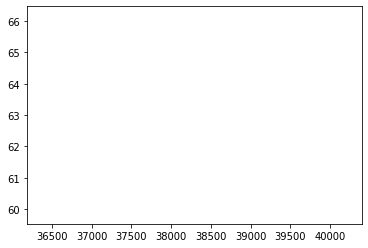

In [ ]:
result[result['cate_grp'] == 'Food'][result['freq'] == 63]['freq'].plot()

<AxesSubplot:>

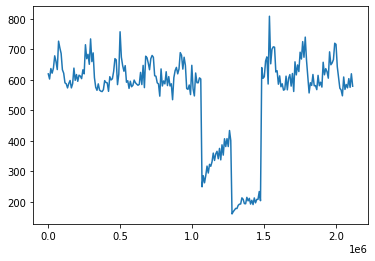

In [ ]:
result[result['xy'] == 30068]['total_exist'].plot()

<AxesSubplot:>

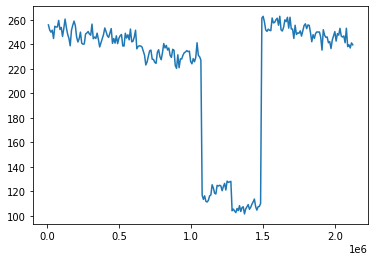

In [ ]:
result[result['xy'] == 164049]['exist_m_40'].plot()

<AxesSubplot:>

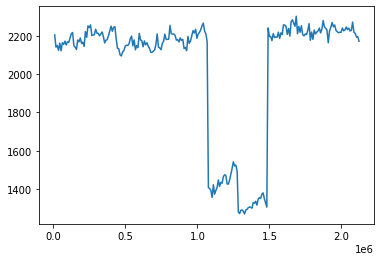

In [ ]:
result[result['xy'] == 164049]['total_exist'].plot()

In [ ]:
import pandas as pd
data = pd.read_csv('./data/result_df.csv')

In [ ]:
data.head()

,Unnamed: 0,datetime,xy,x,y,exist_m_00,exist_m_10,exist_m_20,exist_m_30,exist_m_40,...,in_f_40,in_f_50,in_f_60,in_f_70,in_f_80,in_f_90,total_exist,total_home,total_work,total_in
0,0,202103080900,1121,1,121,0.00,0.01,0.28,0.68,0.63,...,0.38,0.23,0.07,0.06,0.01,0.00,4.84,1.22,0.60,3.16
1,1,202103080900,1122,1,122,0.52,0.27,1.02,1.88,1.80,...,0.95,0.56,0.22,0.30,0.03,0.00,15.38,4.67,0.94,9.70
2,2,202103080900,1123,1,123,0.85,0.94,2.36,5.19,4.59,...,2.07,1.19,0.60,0.61,0.15,0.01,44.96,19.81,4.43,20.24
3,3,202103080900,2120,2,120,0.00,0.45,0.34,0.78,0.76,...,0.17,0.15,0.08,0.05,0.01,0.00,6.79,4.20,0.42,3.10
4,4,202103080900,2121,2,121,0.32,0.45,1.40,1.96,2.33,...,1.08,0.63,0.23,0.33,0.05,0.02,19.12,6.77,2.05,10.29


<AxesSubplot:>

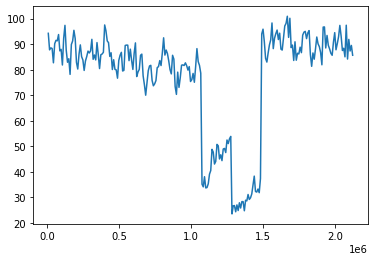

In [ ]:
data[data['xy'] == 164049]['in_m_40'].plot()

<AxesSubplot:>

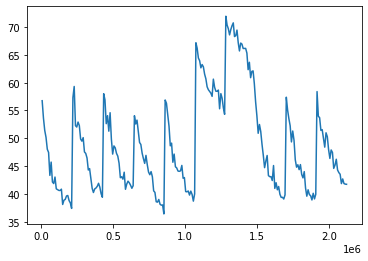

In [ ]:
data[data['xy'] == 164049]['home_m_40'].plot()

<AxesSubplot:>

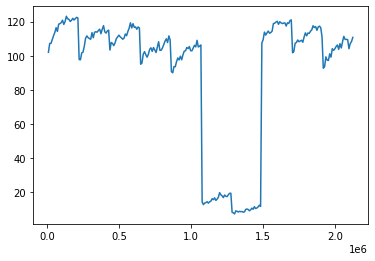

In [ ]:
data[data['xy'] == 164049]['work_m_40'].plot()

<AxesSubplot:>

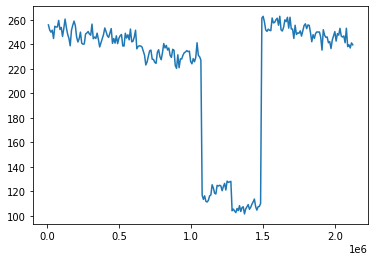

In [ ]:
data[data['xy'] == 164049]['exist_m_40'].plot()

<AxesSubplot:>

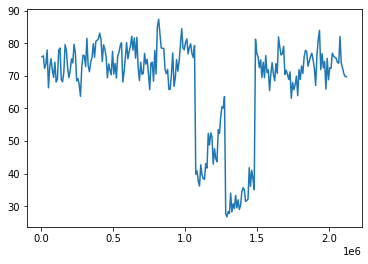

In [ ]:
data[data['xy'] == 164049]['in_m_50'].plot()

<AxesSubplot:>

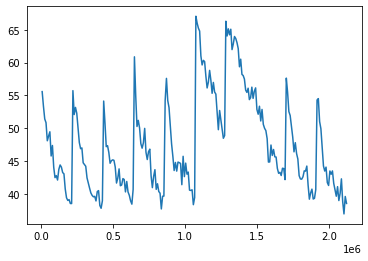

In [ ]:
data[data['xy'] == 164049]['home_m_50'].plot()

<AxesSubplot:>

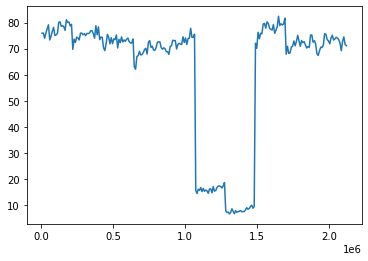

In [ ]:
data[data['xy'] == 164049]['work_m_50'].plot()

<AxesSubplot:>

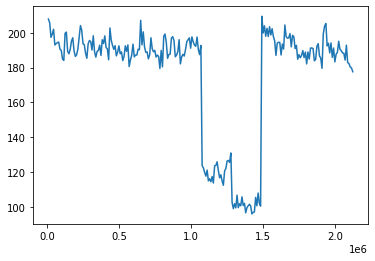

In [ ]:
data[data['xy'] == 164049]['exist_m_50'].plot()

<AxesSubplot:>

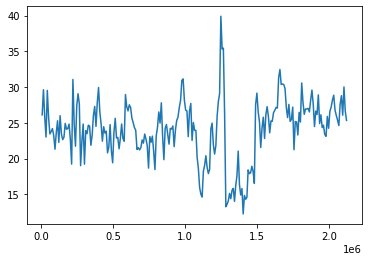

In [ ]:
data[data['xy'] == 164049]['in_f_20'].plot()

<AxesSubplot:>

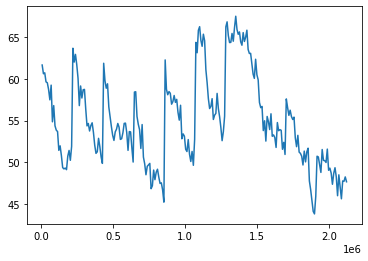

In [ ]:
data[data['xy'] == 164049]['home_f_20'].plot()

<AxesSubplot:>

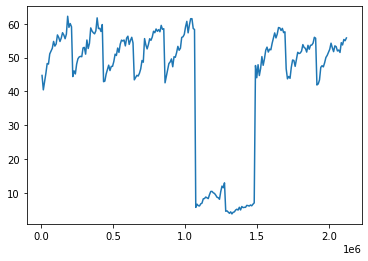

In [ ]:
data[data['xy'] == 164049]['work_f_20'].plot()

<AxesSubplot:>

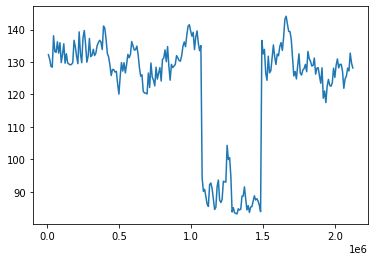

In [ ]:
data[data['xy'] == 164049]['exist_f_20'].plot()